In [2]:
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
import logging

# 로그 설정
logging.basicConfig(filename='download_errors.log', level=logging.ERROR)

# 경고 무시
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## 데이터 다운로드

In [ ]:
# NYSE
# NasdaqGS
# NasdaqGM
# AMEX
# Ticker.csv 읽기
ticker_df = pd.read_csv('ticker.csv')

# 데이터프레임을 거래소 별로 분할
grouped_by_exchange = ticker_df.groupby('Exchange')
total_data_frames = []

# 각 거래소에 대한 작업
for exchange, group in grouped_by_exchange:
    tickers = group['Symbol'].unique()
    data_frames = []
    
    # 각 종목에 대한 작업
    for ticker in tqdm(tickers, desc=f"Downloading data for exchange {exchange}"):
        try:
            # Yahoo Finance에서 데이터 다운로드
            data = yf.download(ticker
                               , start="2000-01-01"
                               , end="2023-12-31"
                               , progress=False
                               , prepost=False
                               , threads=True
                               , proxy=None)
            
            # 데이터프레임에 종목명 컬럼 추가
            data['TICKER'] = ticker
            data['date'] = data.index.strftime('%Y%m%d')
            # 데이터프레임을 리스트에 추가
            data_frames.append(data)
            
        except Exception as e:
            logging.error(f"Error downloading data for ticker {ticker}: {e}")

    # 거래소별 데이터를 하나의 DataFrame으로 병합
    try:
        high_low_data = pd.concat(data_frames)
        # 별도의 CSV 파일로 저장
        high_low_data.to_parquet(f'./high_low_data_{exchange}.parquet', index=False)
    except ValueError as e:
        logging.error(f"Error processing data for exchange {exchange}: {e}")

## 데이터 전처리

In [3]:
# high_low_data로 시작하는 csv 파일들을 읽어서 하나의 데이터프레임으로 병합
import glob

# glob.glob() 함수를 사용하여 high_low_data로 시작하는 파일들의 경로를 리스트로 저장
# ETF 데이터는 제외

files = glob.glob('./high_low_data_*.parquet')
files = [file for file in files if 'ETF' not in file]

# 각 파일을 읽어서 리스트에 저장
data_frames = []

for file in files:
    temp = pd.read_parquet(file)
    temp["exchange"] = file.split("_")[-1].split(".")[0]
    data_frames.append(temp)
    
# 리스트에 저장된 데이터프레임을 병합
high_low_data = pd.concat(data_frames)
high_low_data['date'] = pd.to_datetime(high_low_data['date'], format='%Y%m%d')

import pandas as pd

# 데이터 준비 (예시 데이터 사용)
# high_low_data['date'] = pd.to_datetime(high_low_data['date'])  # 'date' 열을 datetime 타입으로 변환, 이미 datetime이라면 생략 가능


# 생존편향 무시
# high_low_data['year'] = high_low_data['date'].dt.year

# # 연도별 데이터 개수 계산
# yearly_counts = high_low_data.groupby('year').size()

# # 15년씩 묶었을 때 데이터가 가장 많은 구간 계산
# yearly_counts_rolling = yearly_counts.rolling(window=15).sum()

# # 데이터가 가장 많은 구간의 마지막 연도 찾기
# max_year = yearly_counts_rolling.idxmax()

# # 데이터가 가장 많은 구간의 시작 연도와 종료 연도 계산
# start_year = max_year - 14  # 15년 구간을 포함하기 위해
# end_year = max_year

# (start_year, end_year)

# # 2009~2023 데이터만 추출 (생존편향을 줄이기 위함)
# high_low_data = high_low_data[(high_low_data['year'] >= start_year) & (high_low_data['year'] <= end_year)]

# # 5년 이상 데이터가 있는 종목만 사용
# # 중간에 상장된 종목 제거
# ticker_counts = high_low_data['TICKER'].value_counts()
# ticker_counts = ticker_counts[ticker_counts > 1250]
# ticker_counts

# # 중간에 상장된 종목 제거
# data = high_low_data[high_low_data['TICKER'].isin(ticker_counts.index)]

In [4]:
high_low_data

,Open,High,Low,Close,Adj Close,Volume,TICKER,date,exchange
0,9.500,9.990,8.570,8.750,0.088974,1489000,AACG,2008-01-29,NASDAQ
1,8.750,9.150,8.300,8.500,0.086432,219000,AACG,2008-01-30,NASDAQ
2,8.490,10.300,8.490,9.550,0.097109,182300,AACG,2008-01-31,NASDAQ
3,9.930,9.940,9.500,9.510,0.096702,28200,AACG,2008-02-01,NASDAQ
4,9.500,9.710,9.500,9.500,0.096601,8300,AACG,2008-02-04,NASDAQ
...,...,...,...,...,...,...,...,...,...
1024004,0.211,0.220,0.210,0.218,0.218000,4578400,ZOM,2023-12-22,AMEX
1024005,0.217,0.229,0.215,0.222,0.222000,9352900,ZOM,2023-12-26,AMEX
1024006,0.223,0.228,0.211,0.215,0.215000,5095100,ZOM,2023-12-27,AMEX
1024007,0.216,0.218,0.207,0.210,0.210000,4325300,ZOM,2023-12-28,AMEX


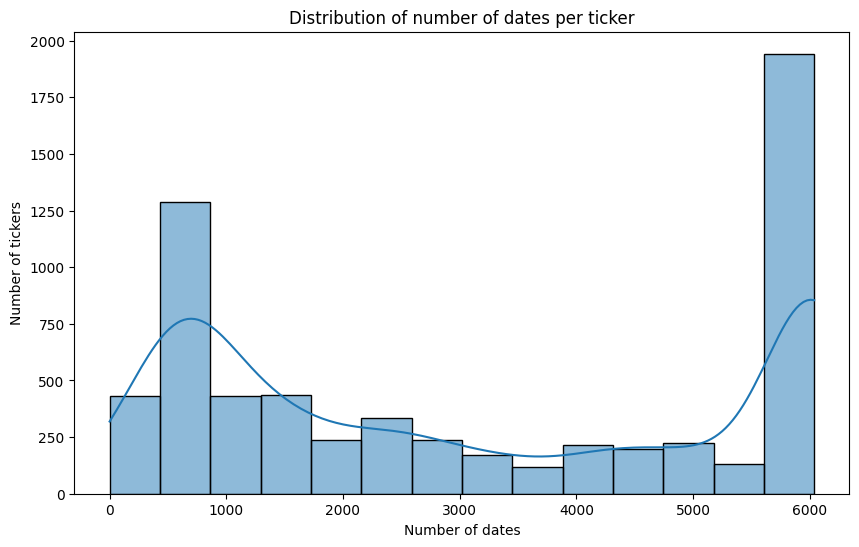

In [5]:
# Ticker 별 그룹화 후 date 분포 확인
data = high_low_data.copy()
data.groupby('TICKER')['date'].nunique().describe()

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# Ticker 별 date 분포
plt.figure(figsize=(10, 6))
sns.histplot(data.groupby('TICKER')['date'].nunique(), kde=True)
plt.title('Distribution of number of dates per ticker')
plt.xlabel('Number of dates')
plt.ylabel('Number of tickers')
plt.show()

In [6]:
# 데이터 프레임의 복사본을 만듭니다.
data_copy = data.copy()

# TICKER와 date 순으로 정렬
data_copy.sort_values(['TICKER', 'date'], inplace=True)

# RET 컬럼 추가
data_copy['Ret'] = data_copy.groupby('TICKER')['Close'].pct_change()

# NaN 값이 있는 행 제거
data_copy.dropna(subset=['Ret'], inplace=True)

# SHROUT 컬럼 추가, NaN으로 채움
data_copy['Shares'] = np.nan

# STOCKID 컬럼 추가, 텍스트 대신 고유 정수값으로 대체
data_copy['StockID'] = data_copy['TICKER'].astype('category').cat.codes

# date 컬럼을 YYYYMMDD 형식으로 변환
data_copy['Date'] = data_copy['date'].dt.strftime('%Y%m%d')

# date 컬럼 제거
data_copy.drop(columns=['date'], inplace=True)

# Close 컬럼을 제거
data_copy.drop(columns=['Close'], inplace=True)

# Adj Close를 Close로 변경
data_copy.rename(columns={'Adj Close': 'Close'}, inplace=True)

# Volume 컬럼을 Vol로 변경
data_copy.rename(columns={'Volume': 'Vol'}, inplace=True)

# 결과 확인
data_copy

,Open,High,Low,Close,Vol,TICKER,exchange,Ret,Shares,StockID,Date
1,48.730328,49.266811,46.316166,40.907444,4765083,A,NYSE,-0.076389,NaN,0,20000104
2,47.389126,47.567955,43.141991,38.369949,5758642,A,NYSE,-0.062030,NaN,0,20000105
3,44.080830,44.349072,41.577251,36.908974,2534434,A,NYSE,-0.038076,NaN,0,20000106
4,42.247852,47.165592,42.203148,39.984726,2819626,A,NYSE,0.083333,NaN,0,20000107
5,49.356224,49.803291,48.327969,42.406872,2148446,A,NYSE,0.060577,NaN,0,20000110
...,...,...,...,...,...,...,...,...,...,...,...
9870315,10.650000,10.740000,10.400000,10.640000,355200,ZYXI,NASDAQ,0.008531,NaN,6396,20231222
9870316,10.640000,10.850000,10.610000,10.710000,165700,ZYXI,NASDAQ,0.006579,NaN,6396,20231226
9870317,10.700000,11.030000,10.700000,10.770000,303500,ZYXI,NASDAQ,0.005602,NaN,6396,20231227
9870318,10.730000,10.950000,10.720000,10.890000,364300,ZYXI,NASDAQ,0.011142,NaN,6396,20231228


In [7]:
# StockID와 TICKER의 관계 확인
ticker_stockid = data_copy[['exchange', 'TICKER', 'StockID']].drop_duplicates()

# 저장
ticker_stockid.to_csv('ticker_stockid.csv', index=False)

In [8]:
columns ={
'Date': 'date',
 'StockID': 'PERMNO',
 'Low': 'BIDLO',
 'High': 'ASKHI',
 'Close': 'PRC',
 'Vol': 'VOL',
 'Shares': 'SHROUT',
 'Open': 'OPENPRC',
 'Ret': 'RET'
 }

# data_copy의 컬럼을 columns을 이용해서 변경
data_copy.rename(columns=columns, inplace=True)

# 해당 컬럼만 추출
data_copy = data_copy[list(columns.values())]

# PERMNO 컬럼을 index로 설정
data_copy.set_index('PERMNO', inplace=True)

In [9]:
# 소수점 3자리까지 반올림
data_copy = data_copy.round(3)
data_copy

,date,BIDLO,ASKHI,PRC,VOL,SHROUT,OPENPRC,RET
PERMNO,,,,,,,,
0,20000104,46.316,49.267,40.907,4765083,NaN,48.730,-0.076
0,20000105,43.142,47.568,38.370,5758642,NaN,47.389,-0.062
0,20000106,41.577,44.349,36.909,2534434,NaN,44.081,-0.038
0,20000107,42.203,47.166,39.985,2819626,NaN,42.248,0.083
0,20000110,48.328,49.803,42.407,2148446,NaN,49.356,0.061
...,...,...,...,...,...,...,...,...
6396,20231222,10.400,10.740,10.640,355200,NaN,10.650,0.009
6396,20231226,10.610,10.850,10.710,165700,NaN,10.640,0.007
6396,20231227,10.700,11.030,10.770,303500,NaN,10.700,0.006


In [10]:
# data_copy를 CSV 파일로 저장
data_copy.to_csv('00-24_UsStockData.csv')

end

In [14]:
# WORK_SPACE/data/stocks_dataset/raw_data/0823UsStockData.csv를 읽기
import pandas as pd
import numpy as np

path = '/home/indi/codespace/PriceTrend/WORK_SPACE/data/stocks_dataset/raw_data/0823UsStockData.csv'
# date 컬럼을 datetime 타입으로 변환하면서 읽기
df = pd.read_csv(
    path,
    parse_dates=["date"],
    dtype={
        "PERMNO": str,
        "BIDLO": np.float64,
        "ASKHI": np.float64,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "OPENPRC": np.float64,
        "RET": object,
        "EXCHCD": np.float64,
    },
    #compression="gzip",
    header=0,
)

df

,date,BIDLO,ASKHI,PRC,VOL,SHROUT,OPENPRC,RET
0,2009-01-05,11.445,12.225,10.962,7171321.0,NaN,11.531,0.034
1,2009-01-06,12.082,13.383,11.837,11834210.0,NaN,12.232,0.08
2,2009-01-07,12.654,13.205,11.902,9974171.0,NaN,12.768,0.006
3,2009-01-08,12.732,13.219,11.980,6242909.0,NaN,12.990,0.007
4,2009-01-09,12.890,13.541,12.091,6917024.0,NaN,13.097,0.009
...,...,...,...,...,...,...,...,...
13846039,2023-12-22,10.400,10.740,10.640,355200.0,NaN,10.650,0.009
13846040,2023-12-26,10.610,10.850,10.710,165700.0,NaN,10.640,0.007
13846041,2023-12-27,10.700,11.030,10.770,303500.0,NaN,10.700,0.006
13846042,2023-12-28,10.720,10.950,10.890,364300.0,NaN,10.730,0.011


In [1]:
# /home/indi/codespace/PriceTrend/WORK_SPACE/data/processed_data/us_ret.feather를 읽기
import pandas as pd
import numpy as np

path = '/home/indi/codespace/PriceTrend/WORK_SPACE/data/processed_data/us_ret.feather'

# 읽기
df = pd.read_feather(path)

In [2]:
df

,Date,StockID,Low,High,Close,Vol,Shares,Open,Ret,MarketCap,...,Ret_month,Ret_quarter,Ret_year,Ret_5d,Ret_20d,Ret_60d,Ret_65d,Ret_180d,Ret_250d,Ret_260d
0,2000-01-04,0,46.316,49.267,40.907,4765083.0,NaN,48.730,-0.076,NaN,...,NaN,NaN,NaN,0.022348,0.149318,0.577724,0.576423,-0.212515,-0.177806,-0.126267
1,2000-01-04,1,96.495,98.298,72.397,1860008.0,NaN,97.246,0.005,NaN,...,NaN,NaN,NaN,0.031762,-0.081954,-0.114788,-0.127209,-0.376744,-0.173205,-0.170430
2,2000-01-04,1001,5.688,5.875,5.227,47800.0,NaN,5.875,0.000,NaN,...,NaN,NaN,NaN,-0.022597,-0.097794,-0.193647,-0.149010,-0.199450,-0.396400,-0.385452
3,2000-01-04,1002,24.000,26.000,25.297,1575.0,NaN,24.000,0.083,NaN,...,NaN,NaN,NaN,-0.143974,-0.153493,-0.037357,0.077822,0.271082,0.173100,0.225667
4,2000-01-04,1012,31.042,32.500,29.986,6540.0,NaN,32.500,-0.039,NaN,...,NaN,NaN,NaN,0.010361,-0.041150,0.001847,-0.025428,0.272090,1.142429,1.275682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20279933,2023-12-29,995,112.890,115.460,113.310,107200.0,NaN,115.450,-0.024,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20279934,2023-12-29,996,21.260,21.860,21.270,2583200.0,NaN,21.810,-0.029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20279935,2023-12-29,997,12.760,12.910,12.830,479700.0,NaN,12.820,0.003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20279936,2023-12-29,998,70.130,71.730,70.170,915400.0,NaN,71.640,-0.025,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# StockID가 0인 데이터 찾기
test1 = df[df['StockID'] == '1']
test1.to_csv('test1.csv', index=False)

In [22]:
# us_freq_ret.pq 열기
import pandas as pd

stock_path = '/home/indi/codespace/PriceTrend/WORK_SPACE/data/processed_data/us_ret.feather'
temp_path = '/home/indi/codespace/PriceTrend/CACHE_DIR/us_freq_ret.pq'

# 읽기
stock = pd.read_feather(stock_path)
us_freq_ret = pd.read_parquet(temp_path)

us_freq_ret

,Date,StockID,MarketCap,next_month_ret,next_month_ret_0delay,Ret_5d,Ret_6-20d,Ret_6-60d
0,1993-01-29,10001,1.512000e+04,0.017857,0.017857,3.240260e-07,0.035714,0.065641
1,1993-01-29,10002,1.369900e+04,0.105263,0.105263,7.894773e-02,0.024390,0.073172
2,1993-01-29,10003,1.042150e+04,-0.078948,-0.078948,-1.052639e-01,0.029412,-0.176469
3,1993-01-29,10009,1.505400e+04,-0.009616,-0.009616,-4.845446e-02,0.040817,0.224494
4,1993-01-29,10010,9.537600e+04,-0.054374,-0.054374,-2.083338e-02,-0.012552,-0.218724
...,...,...,...,...,...,...,...,...
2223505,2019-12-31,93423,3.812878e+06,-0.610460,-0.610460,-3.436065e-02,-0.130165,-0.676398
2223506,2019-12-31,93426,4.249320e+05,-0.251469,-0.251469,-2.294129e-02,0.043650,-0.419625
2223507,2019-12-31,93427,2.399275e+06,0.120136,0.120136,1.897023e-02,0.006809,-0.268355
2223508,2019-12-31,93434,6.994050e+04,0.109526,0.109526,2.380888e-02,0.046510,-0.023255


In [24]:
stock = stock[['Date', 'StockID', 'MarketCap', 'Close', 'Ret']]
stock.head()

,Date,StockID,MarketCap,Close,Ret
0,2009-01-05,0,NaN,10.962,0.034
1,2009-01-05,1,NaN,25.558,-0.021
2,2009-01-05,100,NaN,5.519,-0.123
3,2009-01-05,1002,NaN,17.820,0.001
4,2009-01-05,1004,NaN,1.477,0.000


In [33]:
# next_{freq}_ret를 계산하기 위한 함수
def calculate_next_ret(df, freq):
    # freq에 따라서 다음 달의 Ret을 계산
    # freq가 [Day, Week, onth, Quarter, Year] 중 하나일 때
    # shift에 인자로 넣기 위해 변환
    freq_str = freq
    if freq == 'day': freq = 1
    elif freq == 'week': freq = 5
    elif freq == 'month': freq = 20
    elif freq == 'quarter': freq = 60
    elif freq == 'year': freq = 250
    else: raise ValueError('Invalid frequency')
    
    df[f'next_{freq_str}_ret'] = df.groupby('StockID')['Ret'].shift(-freq)
    return df

# next_{freq}_ret_{d}delay 컬럼을 계산하기 위한 함수
def calculate_next_ret_delay(df, freq, d):
    # freq에 따라서 d일 뒤의 Ret을 계산
    
    freq_str = freq
    if freq == 'day': freq = 1
    elif freq == 'week': freq = 5
    elif freq == 'month': freq = 20
    elif freq == 'quarter': freq = 60
    elif freq == 'year': freq = 250
    else: raise ValueError('Invalid frequency')
    
    df[f'next_{freq_str}_ret_{d}delay'] = df.groupby('StockID')['Ret'].shift(-freq - d)
    return df

# Ret_{start}-{end}d 컬럼을 계산하기 위한 함수
def calculate_ret(df, start, end):
    # start와 end 사이의 Ret을 계산
    df[f'Ret_{start}-{end}d'] = df.groupby('StockID')['Ret'].rolling(end - start + 1).sum().reset_index(0, drop=True)
    return df


# next_{freq}_ret를 계산하기 위한 함수
freq = 'week'
us_freq_ret = stock.copy()

us_freq_ret = calculate_next_ret(us_freq_ret, freq)

# next_{freq}_ret_{d}delay를 계산
us_freq_ret = calculate_next_ret_delay(us_freq_ret, freq, 0)

# Ret_{start}-{end}d를 계산
us_freq_ret = calculate_ret(us_freq_ret, 6, 20)

# Ret_{start}-{end}d를 계산
us_freq_ret = calculate_ret(us_freq_ret, 6, 60)

us_freq_ret.to_parquet(f'/home/indi/codespace/PriceTrend/CACHE_DIR/us_{freq}_ret.pq')

In [28]:
us_freq_ret

,Date,StockID,MarketCap,Close,Ret,next_month_ret,next_month_ret_0delay,Ret_6-20d,Ret_6-60d
0,2009-01-05,0,NaN,10.962,0.034,0.010,0.010,NaN,NaN
1,2009-01-05,1,NaN,25.558,-0.021,0.046,0.046,NaN,NaN
2,2009-01-05,100,NaN,5.519,-0.123,0.009,0.009,NaN,NaN
3,2009-01-05,1002,NaN,17.820,0.001,0.040,0.040,NaN,NaN
4,2009-01-05,1004,NaN,1.477,0.000,0.005,0.005,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13846039,2023-12-29,995,NaN,75.530,-0.004,NaN,NaN,0.070,0.102
13846040,2023-12-29,996,NaN,1.110,0.023,NaN,NaN,-0.079,-0.124
13846041,2023-12-29,997,NaN,0.757,-0.019,NaN,NaN,-0.117,0.131
13846042,2023-12-29,998,NaN,2.780,-0.014,NaN,NaN,0.096,-0.168


In [36]:
processed_data_path = '../WORK_SPACE/data/processed_data/us_ret.feather'

# us_ret.feather를 읽기

import pandas as pd
import numpy as np

df = pd.read_feather(processed_data_path)
df.columns

Index(['Date', 'StockID', 'Low', 'High', 'Close', 'Vol', 'Shares', 'Open',
       'Ret', 'MarketCap', 'log_ret', 'cum_log_ret', 'EWMA_vol', 'Ret_week',
       'Ret_month', 'Ret_quarter', 'Ret_year', 'Ret_5d', 'Ret_20d', 'Ret_60d',
       'Ret_65d', 'Ret_180d', 'Ret_250d', 'Ret_260d'],
      dtype='object')

In [41]:
df.loc[:, ['Date', 'StockID', 'MarketCap', 'Close', 'Ret', 'Ret_week']]

# StockID 0인 데이터만 추출
stock0 = df[df['StockID'] == '0']
stock0 = stock0[['Date', 'StockID', 'MarketCap', 'Close', 'Ret', 'Ret_week']]

In [43]:
stock0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 13841764
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3773 non-null   datetime64[ns]
 1   StockID    3773 non-null   object        
 2   MarketCap  0 non-null      float64       
 3   Close      3773 non-null   float64       
 4   Ret        3773 non-null   float64       
 5   Ret_week   0 non-null      float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 206.3+ KB
